In [ ]:
import pandas as pd
import numpy as np
import pymmwr as pm
import datetime
import warnings
import io
import requests
warnings.simplefilter(action='ignore')
import pdb
import matplotlib.pyplot as plt
import os
import glob
import copy
from itertools import product

In [ ]:
#Some common functions
def get_jhu_raw():
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
    return pd.read_csv(url)

# Read in fips codes and raw health data
fips_codes = pd.read_csv('../../data-locations/locations.csv')
df = get_jhu_raw()

In [ ]:
def get_epi_data(date):
    ''' Get date time in epi fromat'''
    format_str = '%m/%d/%y'  # The format
    dt = datetime.datetime.strptime(date, format_str).date()
    epi = pm.date_to_epiweek(dt)
    return epi.year, epi.week, epi.day

def configure_JHU_data(df, target):
    # convert matrix to repeating row format
    df_truth = df.unstack()
    df_truth = df_truth.reset_index()

    # get epi data from date
    df_truth['year'], df_truth['week'], df_truth['day'] = \
        zip(*df_truth['level_0'].map(get_epi_data))

    # rename columns
    df_truth = df_truth.rename(columns={0: "value",
                                        "level_1": "location_long"})

    # Get state IDs
    df_truth = df_truth.merge(fips_codes, left_on='location_long', right_on='location_name', how='left')

    # Drop NAs
    df_truth = df_truth.dropna(subset=['location', 'value'])

    # add leading zeros to state code
    df_truth['location'] = df_truth['location'].apply(lambda x: '{0:0>2}'.format(x))

    '''
    ####################################
    # Daily truth data output for reference
    ####################################
    '''

    # only output "location", "epiweek", "value"
    df_truth = df_truth.drop(['location_name'], axis=1)
    df_byday = df_truth.rename(columns={"level_0": "date", "location_long": "location_name"})

    # select columns
    df_byday = df_byday[["date", "location", "location_name", "value"]]

    # ensure value column is integer
    df_byday['value'] = df_byday['value'].astype(int)

    # change to yyyy/mm/dd format
    df_byday['date'] = pd.to_datetime(df_byday['date'])

    file_path = '../../data-truth/truth-' + target + '.csv'
    df_byday.to_csv(file_path, index=False)

    '''
    ####################################
    # Truth data output for visualization
    ####################################
    '''
    # Only visualize certain states
    states = ['US', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
              'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
              'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
              'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
              'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
              'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
              'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia']
    df_truth = df_truth[df_truth["location_long"].isin(states)]

    # Observed data on the seventh day
    # or group by week for incident deaths
    if target == 'Incident Deaths':
        df_vis = df_truth.groupby(['week', 'location_long'], as_index=False).agg({'level_0': 'last',
                                                                                  'value': 'sum',
                                                                                  'year': 'last',
                                                                                  'day': 'last',
                                                                                  'location': 'last',
                                                                                  'abbreviation': 'last'})
        df_vis = df_vis[df_vis['day'] == 7]
    else:
        df_vis = df_truth[df_truth['day'] == 7]

    df_vis['week'] = df_vis['week'] + 1  # shift epiweek on axis

    # add leading zeros to epi week
    df_vis['week'] = df_vis['week'].apply(lambda x: '{0:0>2}'.format(x))

    # define epiweek
    df_vis['epiweek'] = df_vis['year'].astype(str) + df_vis['week']

    # Replace US with "nat" this is NECESSARY for visualization code!
    df_vis.loc[df_vis["location_long"] == "US", "abbreviation"] = "nat"

    # only output "location", "epiweek", "value"
    df_truth_short = df_vis[["abbreviation", "epiweek", "value"]]
    df_truth_short = df_truth_short.rename(columns={"abbreviation": "location"})

    df_truth_short["value"].replace({0: 0.1}, inplace=True)

    file_path = '../../visualization/vis-master/covid-csv-tools/dist/truth/' + target + '.json'
    # write to json
    with open(file_path, 'w') as f:
        f.write(df_truth_short.to_json(orient='records'))

In [ ]:
"""
Prepare ground truth data, incident and cummulative deaths, daily 
"""
# aggregate by state and nationally
state_agg = df.groupby(['Province_State']).sum()
us_nat = df.groupby(['Country_Region']).sum()
df_state_nat = state_agg.append(us_nat)

drop_cols = ['UID', 'code3', 'FIPS', 'Lat', 'Long_', 'Population']
# drop unnecessary columns
df_truth = df_state_nat.drop(columns=drop_cols, axis=1)

df_truth_cumulative = df_truth
df_truth_incident = df_truth - df_truth.shift(periods=1, axis='columns')

configure_JHU_data(df_truth_cumulative, "Cumulative Deaths")
configure_JHU_data(df_truth_incident, "Incident Deaths")

state_fips = fips_codes[fips_codes['abbreviation'].notna()]
df_s_merged = df_truth_cumulative.merge(state_fips, left_index=True, right_on='location_name', how='left')
df_states = df_s_merged.loc[df_s_merged.index.dropna()]
df_states.index = df_states.index.astype(np.int64)
df_states.sort_index(inplace=True)

date_columns = df_states.columns[0:-4]
df_states

In [ ]:
"""
Display cummulative deaths by state and overall
"""
df_plot = df_states.set_index('abbreviation')
df_plot = df_plot[date_columns].T

ax = df_plot.plot(kind='line')
ax.legend(loc=(1.01, 0.01), ncol=4)

In [ ]:
"""
Store model prediciotns, organized by dates (can be slow, run as little as possible)
"""

# Skip over certain models that should not be compared
models_to_exclude = [""]

model_predictions = {}
state_fips = fips_codes[fips_codes['abbreviation'].notna()] # State FIPS codes

template = os.path.join('..', '..', 'data-processed','*')
# Number of directories above model name
model_name_index = 3
for model_dir in glob.glob(template):
    mn = model_dir.split(os.path.sep)[model_name_index]
    if mn in models_to_exclude:
        continue
    
    file_template = os.path.join(model_dir, f'*-{mn}.csv')
    for fh in glob.glob(file_template):
        df = pd.read_csv(fh)
        # df = df.merge(state_fips, left_index=True, right_on='location_name', how='left')

        df['location'] = df['location'].astype(str).str.lstrip("0")
    
#         pdb.set_trace()
        forecast_date = df['target_end_date'][0]
#         forecast_date = df['forecast_date'][0]

        # Use code -1 for point tasks
        df.loc[df['type'] == "point", 'quantile'] = -1

        task_df = pd.pivot_table(df, index=['target', 'location', 'quantile']).rename(columns={"value": f"{mn}"})
        
        if forecast_date not in model_predictions:
            model_predictions[forecast_date] = task_df
        else:
            model_predictions[forecast_date] = model_predictions[forecast_date].merge(
                task_df, how='outer', left_index=True, right_index=True)            

In [ ]:
"""
Get list of all task, quantiles, date, model, locations combiations in the dataset  
"""
# Display all possible tasks
all_dates = list(model_predictions.keys())
all_dates.sort()

all_locations = list(state_fips['location'].str.lstrip("0"))

all_models = []
for date in model_predictions.keys():
    all_models = all_models + model_predictions[date].columns.tolist()
all_models = list(set(all_models))

# Populate targets and quantiles present in the dataset 
all_quantiles = None
all_targets = None
for key, value in model_predictions.items():
    # Update targets
    if all_targets is None:
        all_targets = value.index.get_level_values("target").unique()
    else:
        all_targets = all_targets.union(value.index.get_level_values("target")).unique()
        
    # Update quantiles 
    if all_quantiles is None:
        all_quantiles = value.index.get_level_values("quantile").unique()
    else:
        all_quantiles = all_quantiles.union(value.index.get_level_values("quantile")).unique()        

# Convert to lists 
all_targets = list(all_targets)
all_quantiles = list(all_quantiles)

In [ ]:
"""
Initialize dataframe for counting avaliable data, both by task/model and task/date paris
"""
# Set up target, location, quantile index for experiments
quantile = [0.5]
experiments_ind = pd.MultiIndex.from_product([all_targets, all_locations, quantile], names=['target', 'location', 'quantile'])

# Initialize experimental dataframes
experiments_by_model = pd.DataFrame(index=experiments_ind, columns=all_models) 
experiments_by_date = pd.DataFrame(index=experiments_ind, columns=all_dates)
experiments_by_model = experiments_by_model.fillna(0)
experiments_by_date = experiments_by_date.fillna(0)

In [ ]:
# state_abbrev = state_fips
experiments_by_model

In [10]:
"""
Populate the number of present predictions, both by date and by model (can be slow, run as little as possible)
"""
for date in model_predictions.keys():
    sub_df = model_predictions[date][model_predictions[date].index.get_level_values("quantile") == quantile].notna()
    experiments_by_model = experiments_by_model.add(sub_df, fill_value=0)
    experiments_by_date[date].add(sub_df.sum(axis=1), fill_value=0)
    experiments_by_date[date].add(sub_df.sum(axis=1), fill_value=0)  

In [11]:
# Rename location codes to human readable abbreviations
state_abbrev = dict(zip(state_fips['location'].str.strip("0"), state_fips['abbreviation']))
experiments_by_model = experiments_by_model.rename(index=state_abbrev)
experiments_by_date = experiments_by_date.rename(index=state_abbrev)

2020-03-15  2020-03-22  2020-03-27  \
target                location quantile                                       
0 day ahead inc hosp  US       0.5                0           0           0   
                      DE       0.5                0           0           0   
                      KS       0.5                0           0           0   
                      OK       0.5                0           0           0   
                      VT       0.5                0           0           0   
...                                             ...         ...         ...   
99 day ahead inc hosp GU       0.5                0           0           0   
                      MP       0.5                0           0           0   
                      PR       0.5                0           0           0   
                      UM       0.5                0           0           0   
                      VI       0.5                0           0           0   

                                         2020-03-29  2020-03-30  2020-03-31  \
target                location quantile                                       
0 day ahead inc hosp  US       0.5                0           0           0   
                      DE       0.5                0           0           0   
                      KS       0.5                0           0           0   
                      OK       0.5                0           0           0   
                      VT       0.5                0           0           0   
...                                             ...         ...         ...   
99 day ahead inc hosp GU       0.5                0           0           0   
                      MP       0.5                0           0           0   
                      PR       0.5                0           0           0   
                      UM       0.5                0           0           0   
                      VI       0.5                0           0           0   

                                         2020-04-01  2020-04-05  2020-04-06  \
target                location quantile                                       
0 day ahead inc hosp  US       0.5                0           0           0   
                      DE       0.5                0           0           0   
                      KS       0.5                0           0           0   
                      OK       0.5                0           0           0   
                      VT       0.5                0           0           0   
...                                             ...         ...         ...   
99 day ahead inc hosp GU       0.5                0           0           0   
                      MP       0.5                0           0           0   
                      PR       0.5                0           0           0   
                      UM       0.5                0           0           0   
                      VI       0.5                0           0           0   

                                         2020-04-07  ...  2020-10-03  \
target                location quantile              ...               
0 day ahead inc hosp  US       0.5                0  ...           0   
                      DE       0.5                0  ...           0   
                      KS       0.5                0  ...           0   
                      OK       0.5                0  ...           0   
                      VT       0.5                0  ...           0   
...                                             ...  ...         ...   
99 day ahead inc hosp GU       0.5                0  ...           0   
                      MP       0.5                0  ...           0   
                      PR       0.5                0  ...           0   
                      UM       0.5                0  ...           0   
                      VI       0.5                0  ...           0   

                    

In [12]:
"""
Count the number of dates for each task in which we have at least N models making predictions 
"""
N = 5
n_dates = (experiments_by_date >= N).sum(axis=1)
df_withn = copy.copy(experiments_by_model).rename(index=state_abbrev)
df_withn[f'geq{N}'] = n_dates
df_withn = df_withn[[f'geq{N}'] + list(df_withn.columns[0:-2])] # reorder columns so geqN is near front 
df_withn_sorted = df_withn.sort_values(by=f"geq{N}", ascending=False)
print("Total number of tasks/locations/models:", df_withn_sorted.shape)
print("Max number of dates with N models for any task:", (experiments_by_date > N).sum(axis=1).max())

"""
Display and write to csv file the sorted value
"""
df_withn_sorted.to_csv(f"./sort-top{N}-q{quantile}.csv", sep=",")
df_withn_sorted.head(40)

Total number of tasks/locations/models: (35518, 73)
Max number of dates with N models for any task: 0


geq5 Auquan-SEIR BPagano-RtDriven  \
target                location quantile                                      
0 day ahead inc hosp  10       0.5        0.0           0                0   
55 day ahead inc hosp 10       0.5        0.0           0                0   
56 day ahead inc hosp 10       0.5        0.0           0                0   
55 day ahead inc hosp US       0.5        0.0           0                0   
                      60       0.5        0.0           0                0   
                      50       0.5        0.0           0                0   
                      40       0.5        0.0           0                0   
                      30       0.5        0.0           0                0   
                      20       0.5        0.0           0                0   
54 day ahead inc hosp US       0.5        0.0           0                0   
56 day ahead inc hosp 30       0.5        0.0           0                0   
54 day ahead inc hosp 60       0.5        0.0           0                0   
                      50       0.5        0.0           0                0   
                      40       0.5        0.0           0                0   
                      30       0.5        0.0           0                0   
                      20       0.5        0.0           0                0   
                      10       0.5        0.0           0                0   
53 day ahead inc hosp US       0.5        0.0           0                0   
56 day ahead inc hosp 20       0.5        0.0           0                0   
                      40       0.5        0.0           0                0   
5 wk ahead inc case   10       0.5        0.0           0                0   
57 day ahead inc hosp US       0.5        0.0           0                0   
58 day ahead inc hosp US       0.5        0.0           0                0   
                      60       0.5        0.0           0                0   
                      50       0.5        0.0           0                0   
                      40       0.5        0.0           0                0   
                      30       0.5        0.0           0                0   
                      20       0.5        0.0           0                0   
                      10       0.5        0.0           0                0   
57 day ahead inc hosp 60       0.5        0.0           0                0   
56 day ahead inc hosp 50       0.5        0.0           0                0   
57 day ahead inc hosp 50       0.5        0.0           0                0   
                      40       0.5        0.0           0                0   
                      30       0.5        0.0           0                0   
                      20       0.5        0.0           0                0   
                      10       0.5        0.0           0                0   
56 day ahead inc hosp US       0.5        0.0           0                0   
                      60       0.5        0.0           0                0   
53 day ahead inc hosp 60       0.5        0.0           0                0   
                      50       0.5        0.0           0                0   

                                        CDDEP-SEIR_MCMC CEID-Walk  \
target                location quantile                             
0 day ahead inc hosp  10       0.5                    0         0   
55 day ahead inc hosp 10       0.5                    0         0   
56 day ahead inc hosp 10       0.5                    0         0   
55 day ahead inc hosp US       0.5                    0         0   
                      60       0.5                    0         0   
                      50       0.5                    0         0   
                      40       0.5                    0         0   
                      30       0.5                    0         0   
                      20       0.5                    0         0   
54 da

In [13]:
"""
Query avaliability for a specific task
"""
task = '1 wk ahead cum death'
quantile = 0.5
location = 'US'

df_experiment = pd.DataFrame(index=all_models, columns=all_dates)
df_experiment = df_experiment.fillna(0)
for date in model_predictions.keys():
    sub_df = model_predictions[date].query(f"target == '{task}' and quantile == '{quantile}' and location == '{location}'").notna()
    if sub_df.shape[0] != 1: 
        print(f"Warning: {sub_df.shape[0]} model predictions found for task on date {date}")
        continue
    df_experiment[date] = df_experiment[date].add(sub_df.iloc[0], fill_value=0)

76


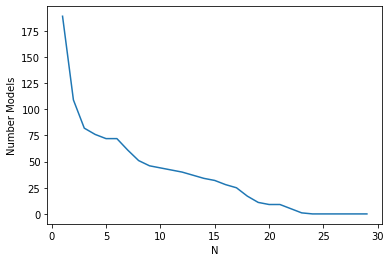

In [14]:
"""
Plot data avaliblity as number of dates with >= N dates avalible
"""
n_avail = []
for n in range(1, 30):
    n_avail.append((df_experiment.sum(axis=0) >= n).sum())
plt.plot(range(1,30), n_avail)
plt.xlabel('N')
plt.ylabel('Number Models')

print((df_experiment.sum(axis=0) >= 4).sum())

In [15]:
"""
Disaply and write avaliblity to file
"""
print("Avalilbity by date")
display(df_experiment.sum(axis=0))
print("Avalilbity by model")
display(df_experiment.sum(axis=1).sort_values(ascending=False))

# Sort models/rows by the number of dates avaliable
row_index = df_experiment.sum(axis=1).sort_values(ascending=False).index
df_experiment_sort = df_experiment.loc[row_index, :]

df_experiment_sort['total_dates'] = df_experiment_sort.sum(axis=1)
df_experiment_sort.loc['total_models'] = df_experiment_sort.sum(axis=0)
df_experiment_sort = df_experiment_sort.loc[['total_models'] + list(df_experiment_sort.index[0:-1]), ['total_dates'] + list(df_experiment.columns)]

print("Model/Date prediction avaliblity")
display(df_experiment_sort)

df_experiment_sort.to_csv(f"./overall-task{''.join(task.split())}-q{quantile}-location{location}.csv", sep=",")

Avalilbity by date


2020-03-15     2.0
2020-03-22     2.0
2020-03-27     0.0
2020-03-29     2.0
2020-03-30     0.0
              ... 
2020-10-12    18.0
2020-10-15     6.0
2020-10-16     1.0
2020-10-18    13.0
2020-10-19     7.0
Length: 195, dtype: float64

Avalilbity by model


YYG-ParamSearch         176.0
LANL-GrowthRate          53.0
CU-select                46.0
CU-scenario_mid          45.0
CU-scenario_high         45.0
                        ...  
NotreDame-FRED            0.0
UVA-Ensemble              0.0
IQVIA_ACOE-STAN           0.0
Quantori-Multiagents      0.0
IBF-TimeSeries            0.0
Length: 73, dtype: float64

Model/Date prediction avaliblity


,total_dates,2020-03-15,2020-03-22,2020-03-27,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-05,2020-04-06,...,2020-10-03,2020-10-04,2020-10-05,2020-10-08,2020-10-11,2020-10-12,2020-10-15,2020-10-16,2020-10-18,2020-10-19
total_models,1092.0,2,2,0.0,2,0.0,0.0,0.0,2,1,...,1,22,17,6,21,18,6,1,13,7
YYG-ParamSearch,176.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,1,1,1,0,0,0,0,0,0,0
LANL-GrowthRate,53.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,0,1,1,0,1,1,0,0,0
CU-select,46.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,1,0,1,1,0,1,0,1,0
CU-scenario_mid,45.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,1,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NotreDame-FRED,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
UVA-Ensemble,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
IQVIA_ACOE-STAN,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quantori-Multiagents,0.0,0,0,0.0,0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# # experiments_by_model.astype('float').nlargest(10, columns=experiments_by_model.columns)
# rows_index=experiments_by_model.max(axis=1).sort_values(ascending=False).index
# col_index=experiments_by_model.max().sort_values(ascending=False).index
# new_df=experiments_by_model.loc[rows_index,col_index].rename(index=state_abbrev)
# new_df.to_csv(f"~/Documents/max-q{quantile[0]}.csv", sep=",")
# new_df.head(40)

In [18]:
# df_experiment_sort